# Durham Daily Temperature Prediction

## Background
This project aims to predict the daily temperature for Durham in 2020 based on historical temperature records from 1900 to 2019. The dataset includes daily measurements of rainfall, average temperature, minimum temperature and maximum temperature.

## Objective
The main objective is to develop a predictive model that accurately forecasts the daily temperature for Durham in 2020. This involves:

- Exploring and preprocessing the dataset
- Selecting and implementing a suitable forecasting model
- Evaluating the model's performance and making predictions for 2020

## Methodology
The project will follow these steps:

1. **Data Preprocessing**: Load, explore and preprocess the dataset for modeling.

2. **Feature Engineering**: Extract relevant features for temperature prediction, such as seasonality indicators.

3. **Model Selection and Training**: Evaluate and select the best-fitting forecasting model and train it using data from 1900 to 2019.

4. **Model Evaluation**: Assess the model's performance using cross-validation techniques and fine-tune parameters as needed.

5. **Prediction and Visualization**: Predict the daily average temperature for 2020 and visualize the predictions alongside historical data.

6. **Analysis and Report**: Analyze the model's predictions, discuss limitations and explore potential improvements.

**0. Import Packages**

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from scipy import stats
from prophet import Prophet

**1. Data Preprocessing**

In [150]:
# Load the dataset
data_path = 'durhamtemp_1901_2019.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset
print("Original Dataset:")
print(data.head())

Original Dataset:
     Year  Month  Day        Date  PPT.   Av temp  Tmax  Tmin
0  1901.0    1.0  1.0  01/01/1901    0.0      2.1   3.5   0.6
1  1901.0    1.0  2.0  02/01/1901    0.0      4.0   7.2   0.7
2  1901.0    1.0  3.0  03/01/1901    0.0      3.0   6.7  -0.7
3  1901.0    1.0  4.0  04/01/1901    0.0      3.7   7.9  -0.6
4  1901.0    1.0  5.0  05/01/1901    0.0     -0.3   1.2  -1.7


In [151]:
# Drop rows where all elements are NaN (maybe deleted manually)
data.dropna(how='all', inplace=True)

# Check for missing values
print("Checking for missing values:")
print(data.isnull().sum())
print("\n")

# Check data types
print("Data types:")
print(data.dtypes)
print("\n")

# If 'Date' is the index, reset it back to a column
if 'Date' not in data.columns:
    data.reset_index(inplace=True)

# Convert date columns to datetime type
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# Set the date column as the index of the dataframe
data.set_index('Date', inplace=True)

Checking for missing values:
Year       0
Month      0
Day        0
Date       0
PPT.       0
Av temp    0
Tmax       0
Tmin       0
dtype: int64


Data types:
Year       float64
Month      float64
Day        float64
Date        object
PPT.       float64
Av temp    float64
Tmax       float64
Tmin       float64
dtype: object




In [152]:
print("Dataset with Date as Index:")
print(data.head())

Dataset with Date as Index:
              Year  Month  Day  PPT.   Av temp  Tmax  Tmin
Date                                                      
1901-01-01  1901.0    1.0  1.0    0.0      2.1   3.5   0.6
1901-01-02  1901.0    1.0  2.0    0.0      4.0   7.2   0.7
1901-01-03  1901.0    1.0  3.0    0.0      3.0   6.7  -0.7
1901-01-04  1901.0    1.0  4.0    0.0      3.7   7.9  -0.6
1901-01-05  1901.0    1.0  5.0    0.0     -0.3   1.2  -1.7


**2. Feature Engineering**

In [153]:
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day

data['DayOfYear'] = data.index.dayofyear

data['WeekOfYear'] = data.index.isocalendar().week

data['DayOfWeek'] = data.index.dayofweek

data['Quarter'] = data.index.quarter

# 0 for weekdays
# 1 for weekends
data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(int)

# lagged features
data['Tmax_lag1'] = data['Tmax'].shift(1)
data['Tmax_lag2'] = data['Tmax'].shift(2)
data['Tmax_lag3'] = data['Tmax'].shift(3)
data['Tmin_lag1'] = data['Tmin'].shift(1)
data['Tmin_lag2'] = data['Tmin'].shift(2)
data['Tmin_lag3'] = data['Tmin'].shift(3)
data['Av_temp_lag1'] = data['Av temp'].shift(1)
data['Av_temp_lag2'] = data['Av temp'].shift(2)
data['Av_temp_lag3'] = data['Av temp'].shift(3)

# rolling mean features
data['Tmax_rolling_mean_3'] = data['Tmax'].rolling(window=3).mean()
data['Tmax_rolling_mean_7'] = data['Tmax'].rolling(window=7).mean()
data['Tmin_rolling_mean_3'] = data['Tmin'].rolling(window=3).mean()
data['Tmin_rolling_mean_7'] = data['Tmin'].rolling(window=7).mean()
data['Av_temp_rolling_mean_3'] = data['Av temp'].rolling(window=3).mean()
data['Av_temp_rolling_mean_7'] = data['Av temp'].rolling(window=7).mean()

# temperature statistical features
data['Tmax_max'] = data['Tmax'].rolling(window=30).max()
data['Tmax_min'] = data['Tmax'].rolling(window=30).min()
data['Tmax_mean'] = data['Tmax'].rolling(window=30).mean()
data['Tmax_median'] = data['Tmax'].rolling(window=30).median()
data['Tmax_std'] = data['Tmax'].rolling(window=30).std()

data['Tmin_max'] = data['Tmin'].rolling(window=30).max()
data['Tmin_min'] = data['Tmin'].rolling(window=30).min()
data['Tmin_mean'] = data['Tmin'].rolling(window=30).mean()
data['Tmin_median'] = data['Tmin'].rolling(window=30).median()
data['Tmin_std'] = data['Tmin'].rolling(window=30).std()

data['Av_temp_max'] = data['Av temp'].rolling(window=30).max()
data['Av_temp_min'] = data['Av temp'].rolling(window=30).min()
data['Av_temp_mean'] = data['Av temp'].rolling(window=30).mean()
data['Av_temp_median'] = data['Av temp'].rolling(window=30).median()
data['Av_temp_std'] = data['Av temp'].rolling(window=30).std()

# temperature difference features
data['Temp_diff'] = data['Tmax'] - data['Tmin']
data['Tmax_diff'] = data['Tmax'] - data['Av temp']
data['Tmin_diff'] = data['Tmin'] - data['Av temp']

In [154]:
print("Dataset with Engineered Features:")
print(data.head())

Dataset with Engineered Features:
            Year  Month  Day  PPT.   Av temp  Tmax  Tmin  DayOfYear  \
Date                                                                  
1901-01-01  1901      1    1    0.0      2.1   3.5   0.6          1   
1901-01-02  1901      1    2    0.0      4.0   7.2   0.7          2   
1901-01-03  1901      1    3    0.0      3.0   6.7  -0.7          3   
1901-01-04  1901      1    4    0.0      3.7   7.9  -0.6          4   
1901-01-05  1901      1    5    0.0     -0.3   1.2  -1.7          5   

            WeekOfYear  DayOfWeek  ...  Tmin_median  Tmin_std  Av_temp_max  \
Date                               ...                                       
1901-01-01           1          1  ...          NaN       NaN          NaN   
1901-01-02           1          2  ...          NaN       NaN          NaN   
1901-01-03           1          3  ...          NaN       NaN          NaN   
1901-01-04           1          4  ...          NaN       NaN          NaN   


**2.5. Data Visualize**

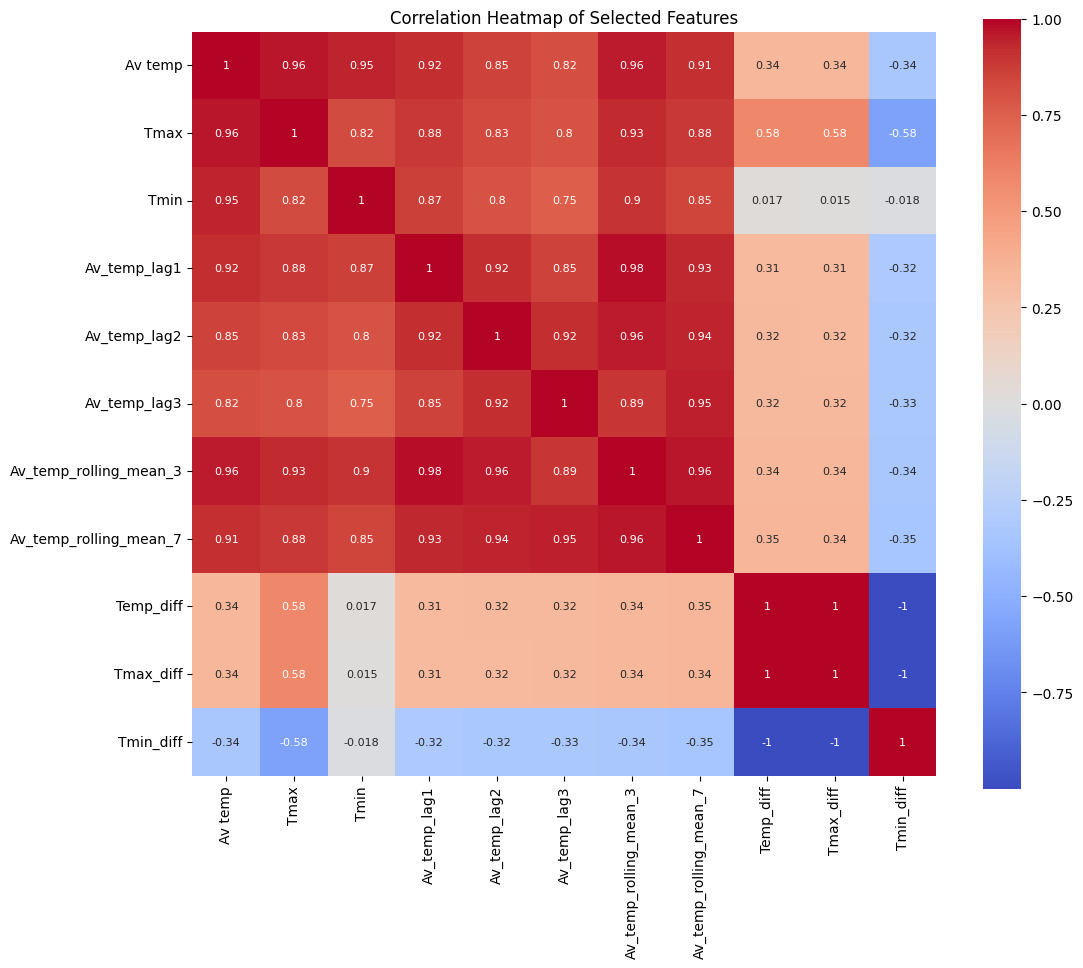

In [155]:
# Select a subset of features for the heatmap
subset_features = ['Av temp', 'Tmax', 'Tmin', 'Av_temp_lag1', 'Av_temp_lag2', 'Av_temp_lag3', 'Av_temp_rolling_mean_3', 'Av_temp_rolling_mean_7', 'Temp_diff', 'Tmax_diff', 'Tmin_diff']

# Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = data[subset_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True, annot_kws={"size": 8})
plt.title('Correlation Heatmap of Selected Features')
plt.show()

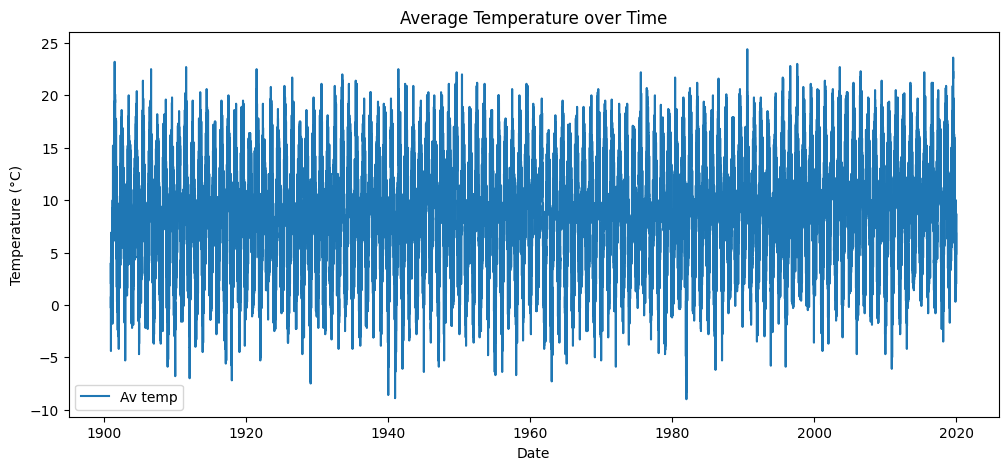

In [156]:
# Average Temperature over Time
temp_features = ['Av temp']
plt.figure(figsize=(12, 5))
for feature in temp_features:
    plt.plot(data.index, data[feature], label=feature)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Average Temperature over Time')
plt.legend()
plt.show()

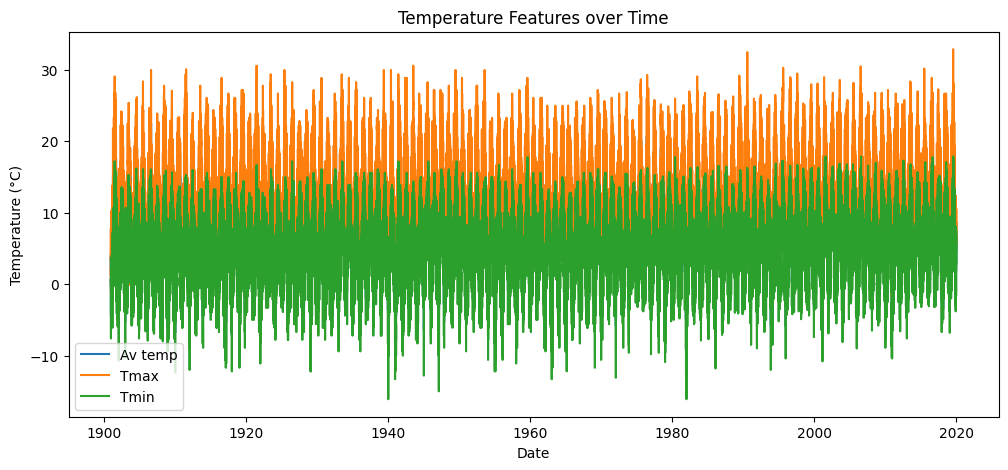

In [157]:
# Temperature Features over Time
temp_features = ['Av temp', 'Tmax', 'Tmin']
plt.figure(figsize=(12, 5))
for feature in temp_features:
    plt.plot(data.index, data[feature], label=feature)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Features over Time')
plt.legend()
plt.show()

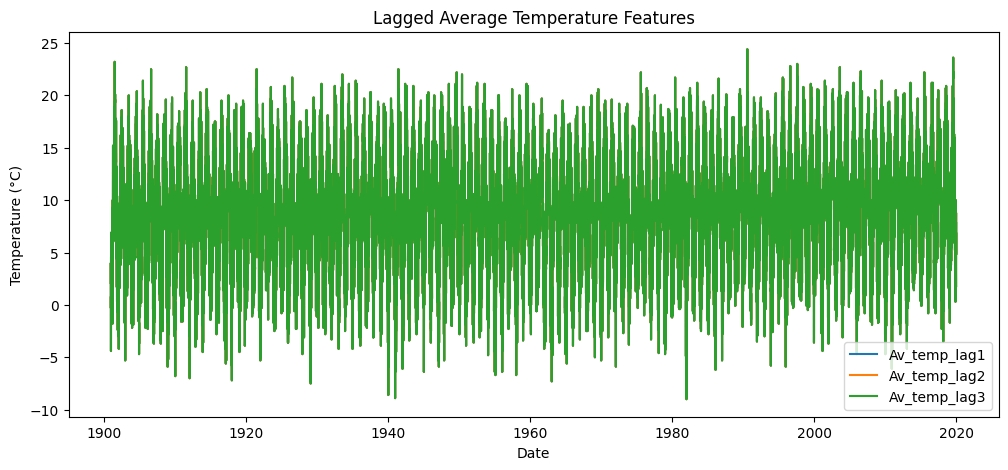

In [158]:
# Lagged Temperature Features
lagged_features = ['Av_temp_lag1', 'Av_temp_lag2', 'Av_temp_lag3']
plt.figure(figsize=(12, 5))
for feature in lagged_features:
    plt.plot(data.index, data[feature], label=feature)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Lagged Average Temperature Features')
plt.legend()
plt.show()

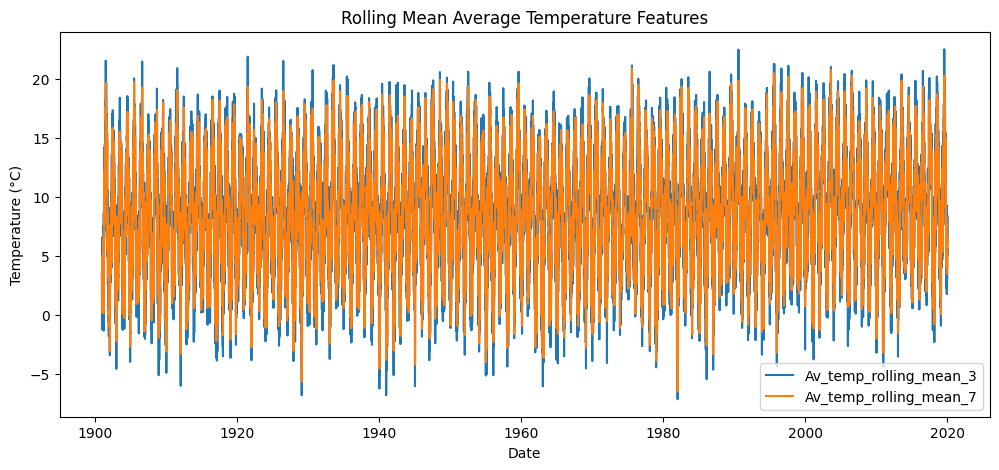

In [159]:
# Rolling Mean Temperature Features
rolling_features = ['Av_temp_rolling_mean_3', 'Av_temp_rolling_mean_7']
plt.figure(figsize=(12, 5))
for feature in rolling_features:
    plt.plot(data.index, data[feature], label=feature)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Rolling Mean Average Temperature Features')
plt.legend()
plt.show()

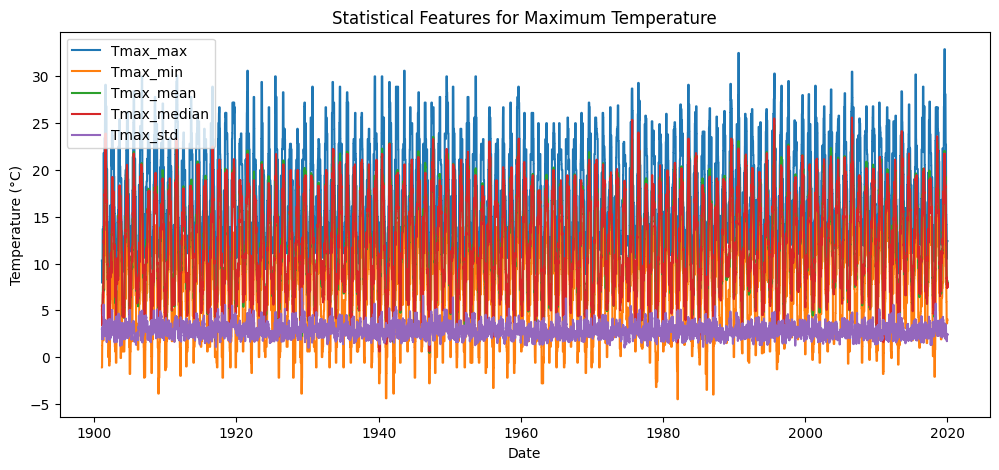

In [160]:
# Statistical Features for Tmax
tmax_stats = ['Tmax_max', 'Tmax_min', 'Tmax_mean', 'Tmax_median', 'Tmax_std']
plt.figure(figsize=(12, 5))
for feature in tmax_stats:
    plt.plot(data.index, data[feature], label=feature)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Statistical Features for Maximum Temperature')
plt.legend()
plt.show()

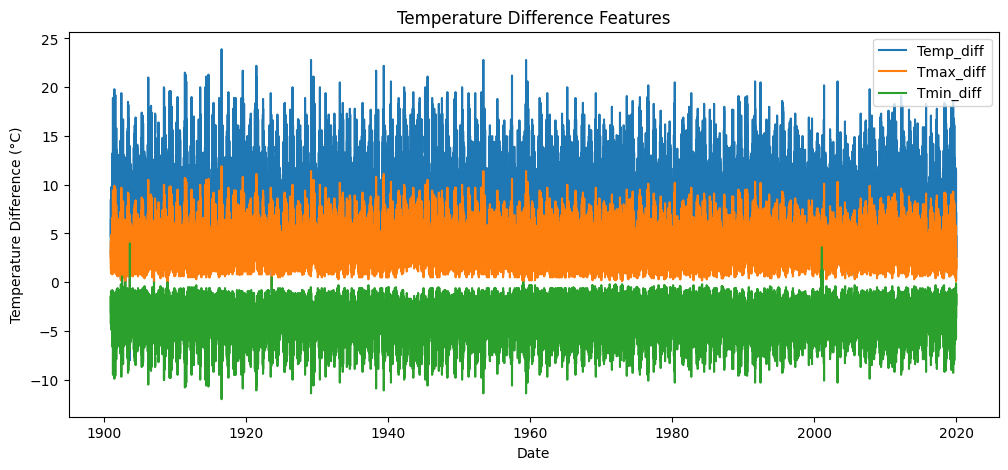

In [161]:
# Temperature Difference Features
diff_features = ['Temp_diff', 'Tmax_diff', 'Tmin_diff']
plt.figure(figsize=(12, 5))
for feature in diff_features:
    plt.plot(data.index, data[feature], label=feature)
plt.xlabel('Date')
plt.ylabel('Temperature Difference (°C)')
plt.title('Temperature Difference Features')
plt.legend()
plt.show()

**3. Model Selection**

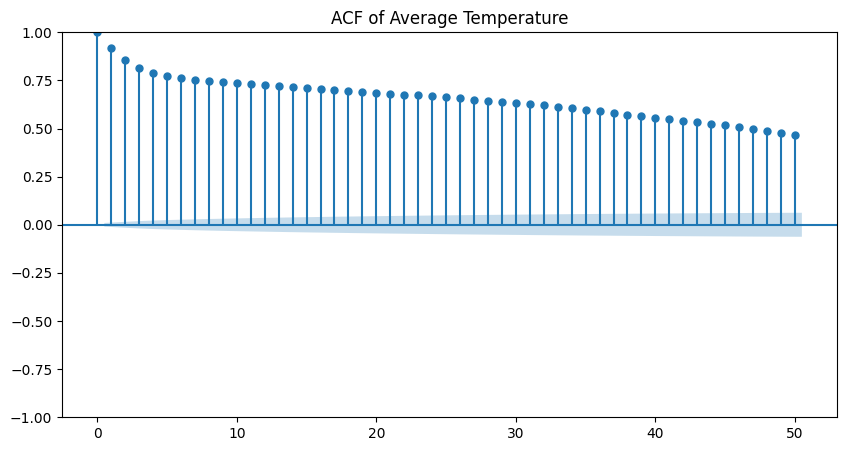

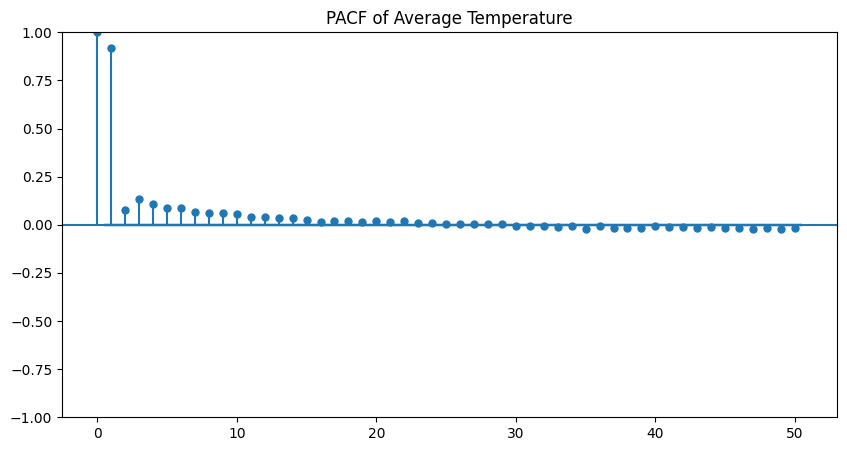

In [162]:
# ACF
plt.figure(figsize=(10, 5))
plot_acf(data['Av temp'], lags=50, ax=plt.gca())
plt.title('ACF of Average Temperature')
plt.show()

# PACF
plt.figure(figsize=(10, 5))
plot_pacf(data['Av temp'], lags=50, ax=plt.gca())
plt.title('PACF of Average Temperature')
plt.show()

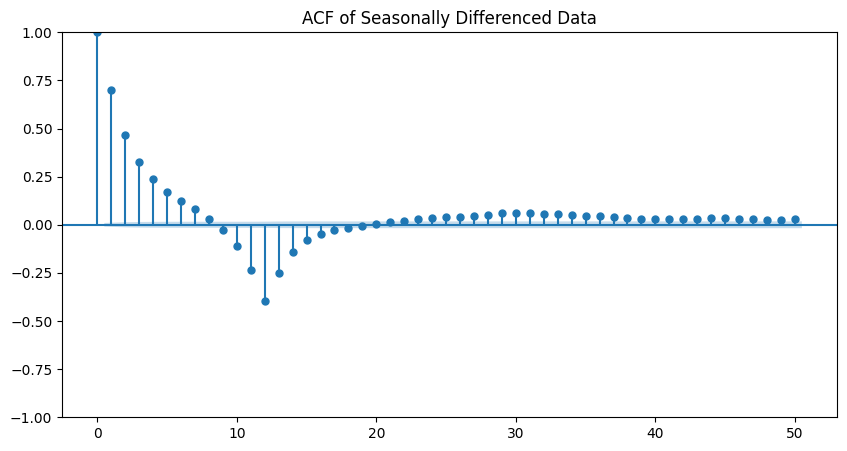

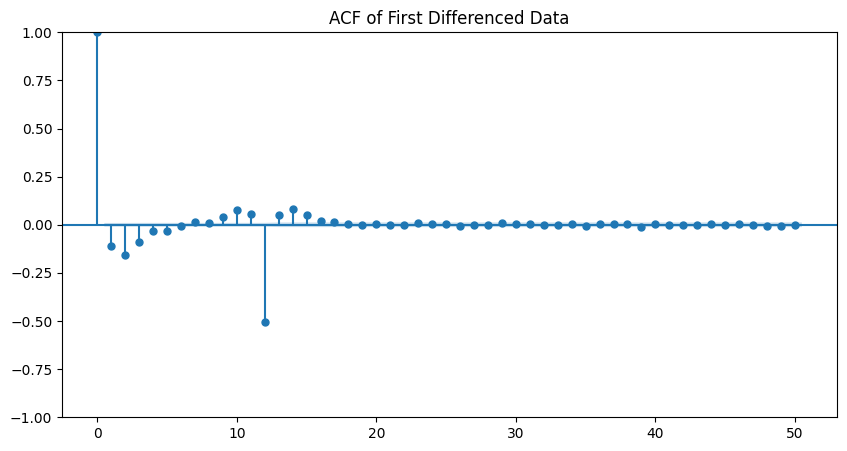

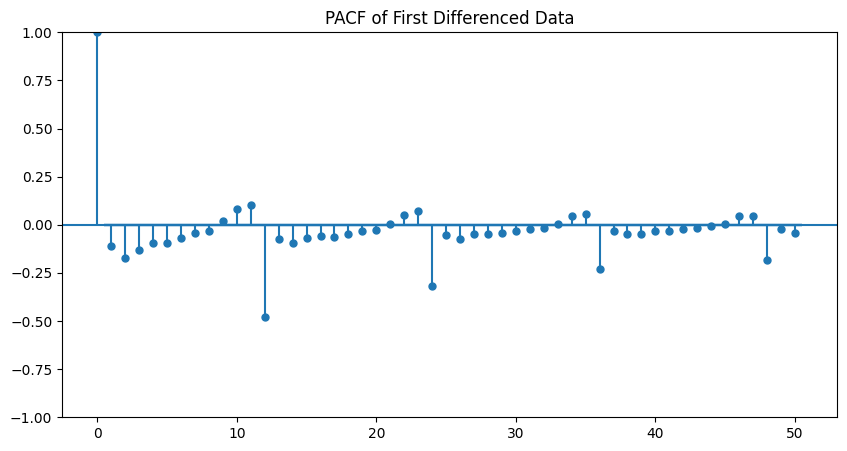

In [163]:
data['temp'] = data['Av temp']

# Seasonal differencing
diff_seasonal = data['temp'].diff(periods=12)
diff_seasonal = diff_seasonal.dropna()

# Plot ACF of seasonally differenced data
plt.figure(figsize=(10, 5))
plot_acf(diff_seasonal, lags=50, ax=plt.gca())
plt.title('ACF of Seasonally Differenced Data')
plt.show()

# First-order differencing
diff_first = diff_seasonal.diff(periods=1)
diff_first = diff_first.dropna()

# Plot ACF of first differenced data
plt.figure(figsize=(10, 5))
plot_acf(diff_first, lags=50, ax=plt.gca())
plt.title('ACF of First Differenced Data')
plt.show()

# Plot PACF of first differenced data
plt.figure(figsize=(10, 5))
plot_pacf(diff_first, lags=50, ax=plt.gca())
plt.title('PACF of First Differenced Data')
plt.show()

Use an external Python code to locate the best SARIMA parameters with Grid Search method.

```python

 def grid_search(data, order_params, seasonal_params, s):
    best_mse = float('inf')
    best_params = None

    for order, seasonal_order in itertools.product(order_params, seasonal_params):
        mse_scores = []
        for train_index, _ in tscv.split(data):
            train_data = data[train_index]
            try:
                mse = evaluate_model(train_data, order, seasonal_order + (s,))
                mse_scores.append(mse)
            except:
                continue
        if len(mse_scores) > 0:
            avg_mse = sum(mse_scores) / len(mse_scores)
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_params = (order, seasonal_order)

    return best_mse, best_params

```

The range of parameters to search is as below.

```python
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 2)
D = range(0, 1)
Q = range(0, 2)
s = 12
```

c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA(1,1,0)(0,1,0,12) Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                43464
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood             -108095.955
Date:                            Fri, 15 Mar 2024   AIC                         216195.910
Time:                                    00:18:25   BIC                         216213.268
Sample:                                01-01-1901   HQIC                        216201.383
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1112      0.005    -24.120      0.000      -0.120      -0.

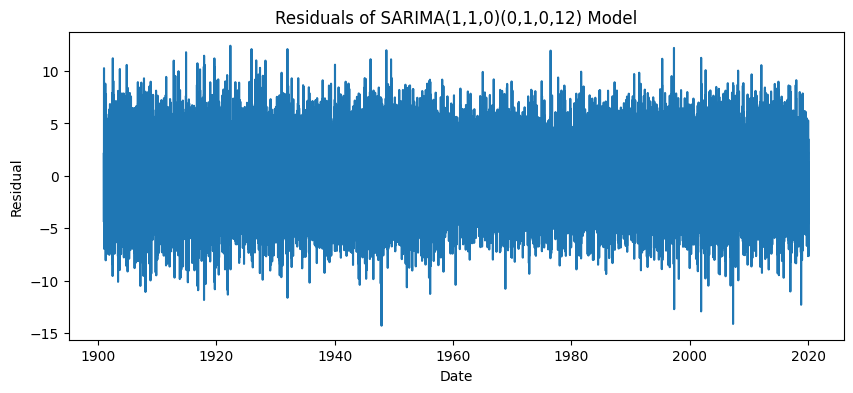

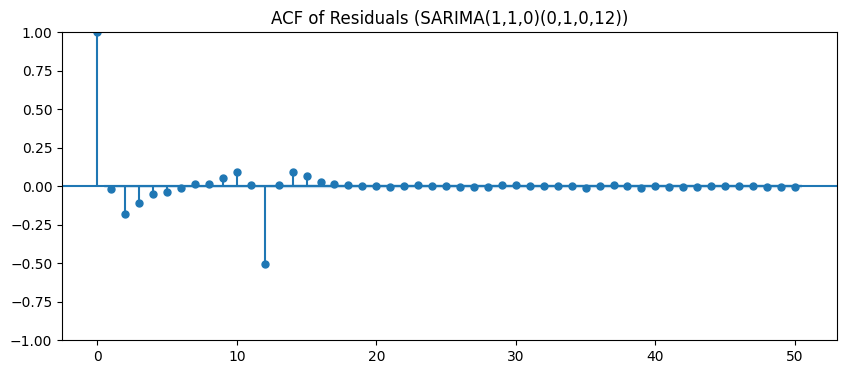

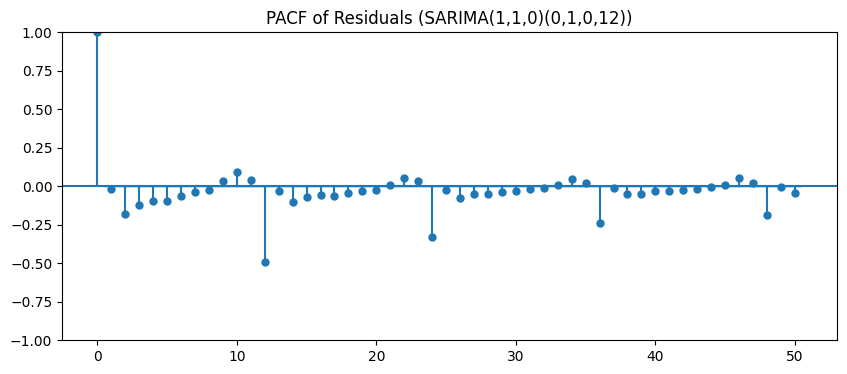

c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA(2,1,0)(0,0,0,12) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                43464
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -92396.193
Date:                Fri, 15 Mar 2024   AIC                         184798.387
Time:                        00:18:39   BIC                         184824.426
Sample:                    01-01-1901   HQIC                        184806.597
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1331      0.004    -30.206      0.000      -0.142      -0.125
ar.L2         -0.1658      0.005    -36.311      0.000      -0.175      -0.157
sigma2       

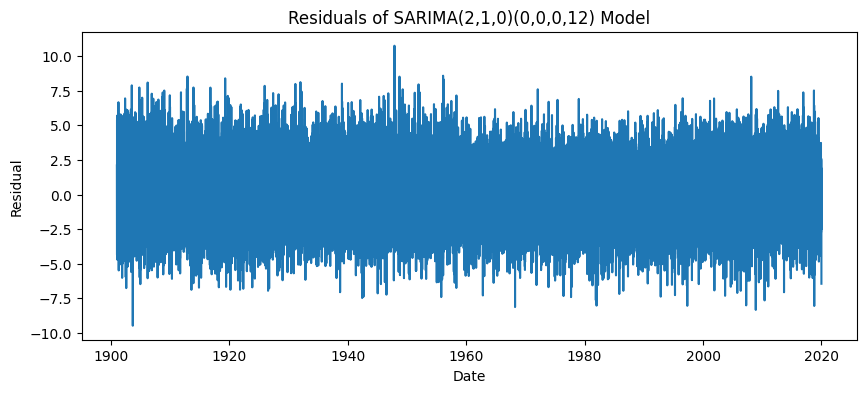

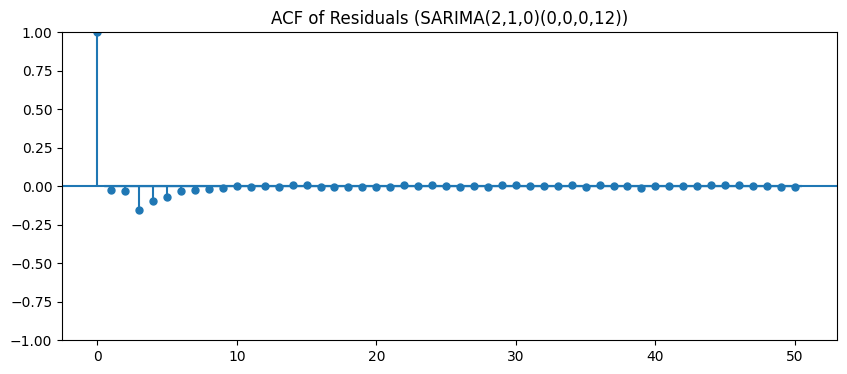

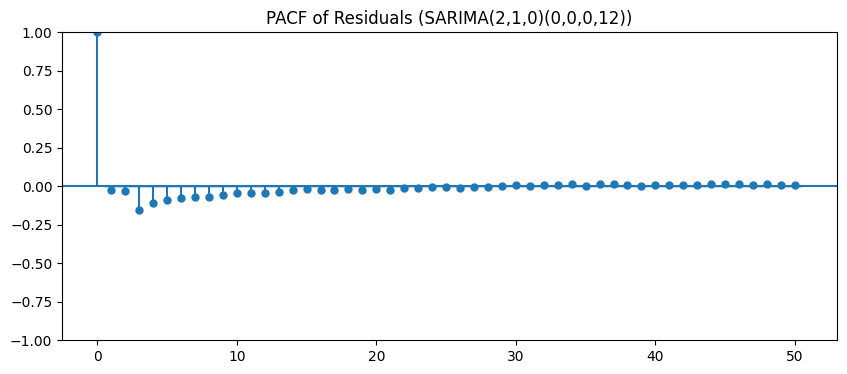

c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA(2,1,3)(0,0,0,12) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                43464
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -90833.393
Date:                Fri, 15 Mar 2024   AIC                         181678.785
Time:                        00:18:59   BIC                         181730.863
Sample:                    01-01-1901   HQIC                        181695.205
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4247      0.468     -0.907      0.365      -1.343       0.493
ar.L2          0.5530      0.264      2.092      0.036       0.035       1.071
ma.L1        

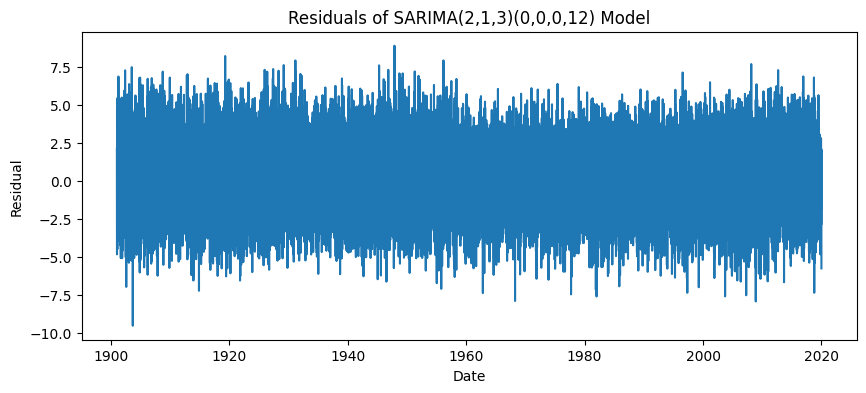

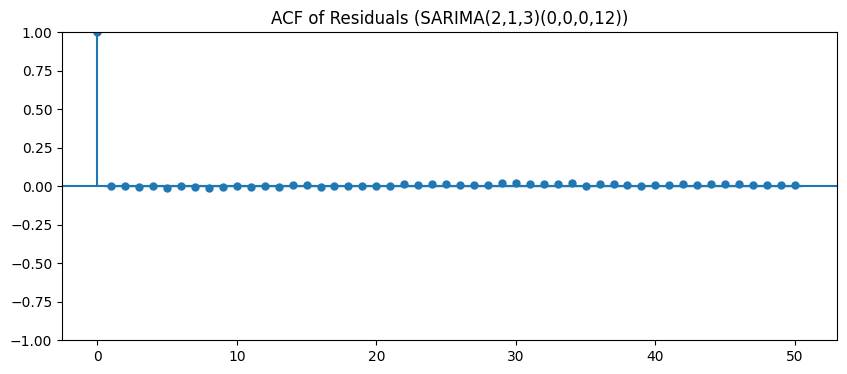

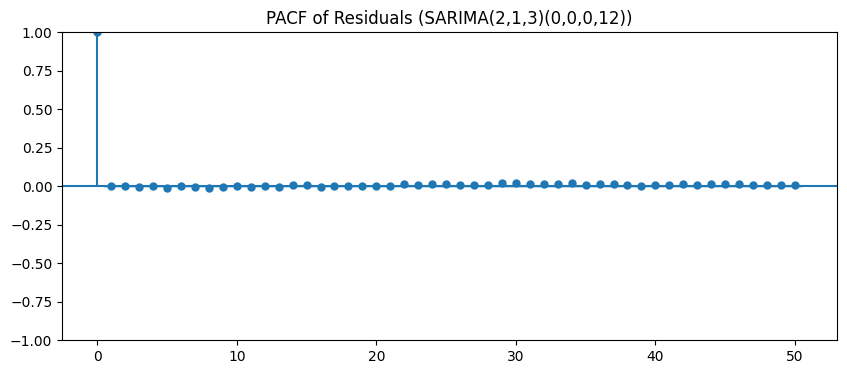

In [164]:
# Define the list of SARIMA model parameters to compare
param_combinations = [
    (1, 1, 0, 0, 1, 0, 12), # Visualization
    (2, 1, 0, 0, 0, 0, 12), # Grid Search
    (2, 1, 3, 0, 0, 0, 12), # Keynote of Time Series
]

for params in param_combinations:
    p, d, q, P, D, Q, s = params
    
    # Fit SARIMA model
    model = SARIMAX(data['temp'], order=(p, d, q), seasonal_order=(P, D, Q, s))
    results = model.fit()
    
    # Print model summary
    print("SARIMA({},{},{})({},{},{},{}) Model Summary:".format(p, d, q, P, D, Q, s))
    print(results.summary())
    
    # Plot residuals
    residuals = results.resid
    plt.figure(figsize=(10, 4))
    plt.plot(residuals)
    plt.title('Residuals of SARIMA({},{},{})({},{},{},{}) Model'.format(p, d, q, P, D, Q, s))
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.show()
    
    # Plot ACF and PACF of residuals
    plt.figure(figsize=(10, 4))
    plot_acf(residuals, lags=50, ax=plt.gca())
    plt.title('ACF of Residuals (SARIMA({},{},{})({},{},{},{}))'.format(p, d, q, P, D, Q, s))
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plot_pacf(residuals, lags=50, ax=plt.gca())
    plt.title('PACF of Residuals (SARIMA({},{},{})({},{},{},{}))'.format(p, d, q, P, D, Q, s))
    plt.show()
    
    print("\n")

**3.5. Model Training**

In [165]:
p, d, q, P, D, Q, s = 2, 1, 0, 0, 0, 0, 12

In [166]:
# Split the dataset into training and testing sets
train_size = int(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]

# Fit the SARIMA model on the training set
model = SARIMAX(train_data['temp'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

# Use the trained model to make predictions on the testing set
start_index = len(train_data)
end_index = len(data) - 1
predictions = results.predict(start=start_index, end=end_index, dynamic=False)

# Evaluate the model's predictive performance on the testing set
mae = mean_absolute_error(test_data['temp'], predictions)
rmse = np.sqrt(mean_squared_error(test_data['temp'], predictions))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 4.29
Root Mean Squared Error (RMSE): 5.16


In [167]:
# Retrain the model using the entire dataset
final_model = SARIMAX(data['temp'], order=(p, d, q), seasonal_order=(P, D, Q, s))
final_results = final_model.fit()
print("Final model summary:")
print(final_results.summary())

c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Final model summary:
                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                43464
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -92396.193
Date:                Fri, 15 Mar 2024   AIC                         184798.387
Time:                        00:19:15   BIC                         184824.426
Sample:                    01-01-1901   HQIC                        184806.597
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1331      0.004    -30.206      0.000      -0.142      -0.125
ar.L2         -0.1658      0.005    -36.311      0.000      -0.175      -0.157
sigma2         4.1117      0.02

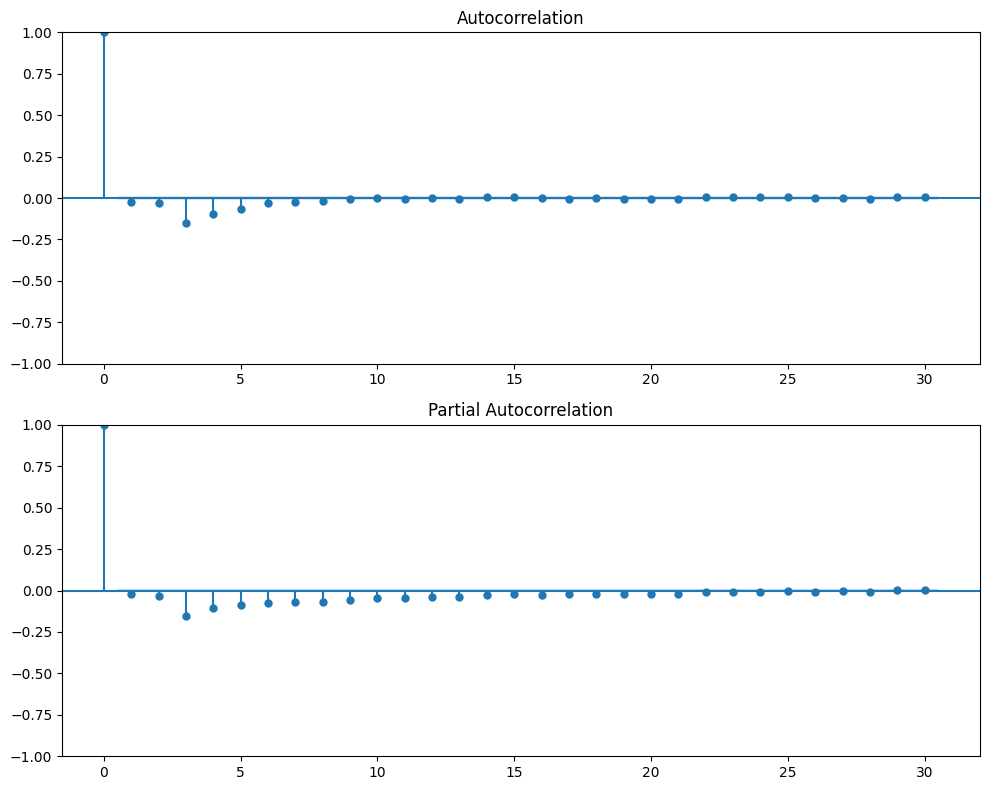

Jarque-Bera test statistic: 352.84, p-value: 0.00
Ljung-Box test statistic: 1736.42, p-value: 0.00


In [168]:
# Residual diagnostics
residuals = final_results.resid

# Plot ACF and PACF of residuals
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, lags=30, ax=ax[0])
plot_pacf(residuals, lags=30, ax=ax[1])
plt.tight_layout()
plt.show()

# Normality test (Jarque-Bera test)
jb_test = stats.jarque_bera(residuals)
print(f"Jarque-Bera test statistic: {jb_test[0]:.2f}, p-value: {jb_test[1]:.2f}")

# Independence test (Ljung-Box test)
lb_test = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
print(f"Ljung-Box test statistic: {lb_test.iloc[0]['lb_stat']:.2f}, p-value: {lb_test.iloc[0]['lb_pvalue']:.2f}")

**4. Model Evaluation**

In [169]:
n_splits = 5
test_size = 365

mae_scores = []
rmse_scores = []

# Initialize the time series cross-validation object
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

for train_index, test_index in tscv.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]
    
    # Fit the model on the training set
    model = SARIMAX(train_data['temp'], order=(p, d, q), seasonal_order=(P, D, Q, s))
    results = model.fit()
    
    # Make predictions on the test set
    start_index = test_data.index[0]
    end_index = test_data.index[-1]
    predictions = results.predict(start=start_index, end=end_index, dynamic=False)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(test_data['temp'], predictions)
    rmse = np.sqrt(mean_squared_error(test_data['temp'], predictions))
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    
    print(f"Split: {tscv.get_n_splits(data)}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    
    
mae_mean = np.mean(mae_scores)
mae_variance = np.var(mae_scores)
rmse_mean = np.mean(rmse_scores)
rmse_variance = np.var(rmse_scores)

print(f"\nMAE - Mean: {mae_mean:.2f}, Variance: {mae_variance:.2f}")
print(f"RMSE - Mean: {rmse_mean:.2f}, Variance: {rmse_variance:.2f}")

c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Split: 5, MAE: 3.45, RMSE: 4.19


c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Split: 5, MAE: 5.94, RMSE: 7.33


c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Split: 5, MAE: 4.19, RMSE: 4.91


c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Split: 5, MAE: 5.34, RMSE: 6.56


c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Split: 5, MAE: 4.08, RMSE: 4.93

MAE - Mean: 4.60, Variance: 0.82
RMSE - Mean: 5.59, Variance: 1.36


**5. Prediction and Visualization**

In [170]:
# Model interpretation
print("Model parameters:")
print(final_results.params)

# Future predictions
future_steps = 366
future_predictions = final_results.forecast(steps=future_steps)

Model parameters:
ar.L1    -0.133149
ar.L2    -0.165820
sigma2    4.111714
dtype: float64


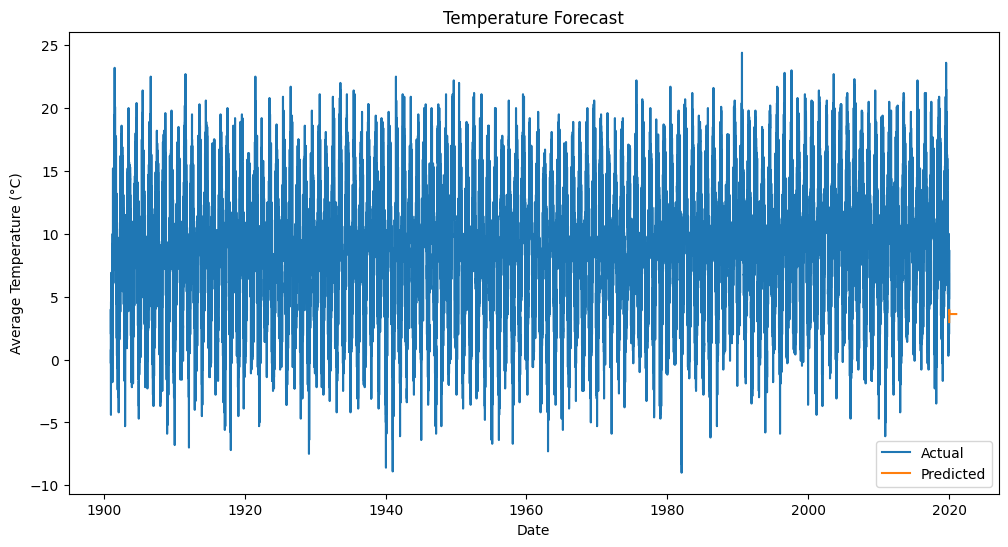

In [171]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['temp'], label='Actual', zorder=1)
plt.plot(future_predictions.index, future_predictions, label='Predicted', zorder=2)
plt.title('Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

**6. Analysis**

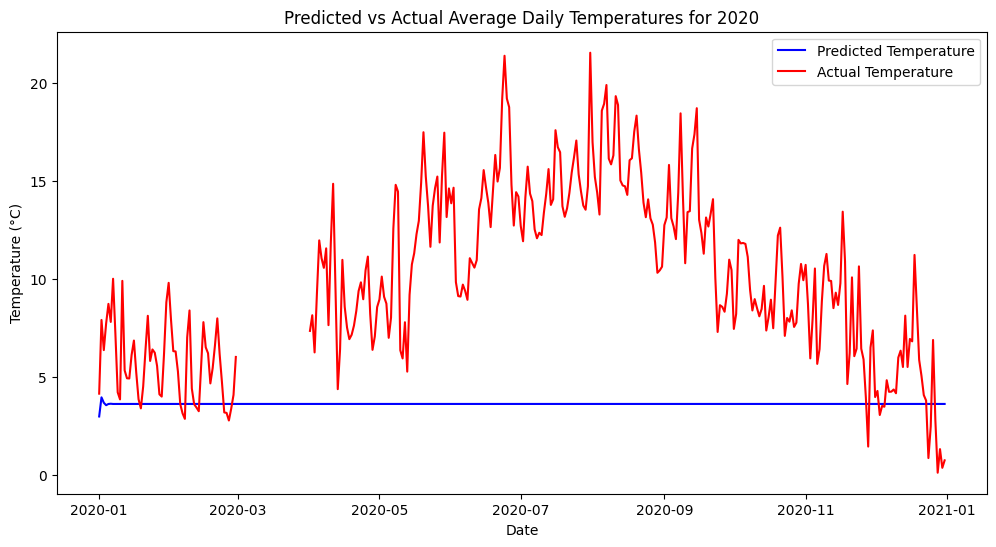

In [172]:
# Load the actual temperature data for 2020
# https://durhamweather.webspace.durham.ac.uk/2020-data/
actual_data_path = 'durhamtemp_2020.csv'
actual_data = pd.read_csv(actual_data_path)

# Convert the date column to datetime format to match the prediction index
actual_data['Date'] = pd.to_datetime(actual_data['Date'], format='%Y-%m-%d')

# Set the date column as the index
actual_data.set_index('Date', inplace=True)

# Ensure the actual data and the predictions have the same index for comparison
actual_data = actual_data.reindex(future_predictions.index)

plt.figure(figsize=(12, 6))
plt.plot(future_predictions, label='Predicted Temperature', color='blue')
plt.plot(actual_data['Av temp'], label='Actual Temperature', color='red')
plt.title('Predicted vs Actual Average Daily Temperatures for 2020')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

NaN values found.
Mean Squared Error (MSE): 60.51
Mean Absolute Error (MAE): 6.56
R-squared ($R^2$): -2.14


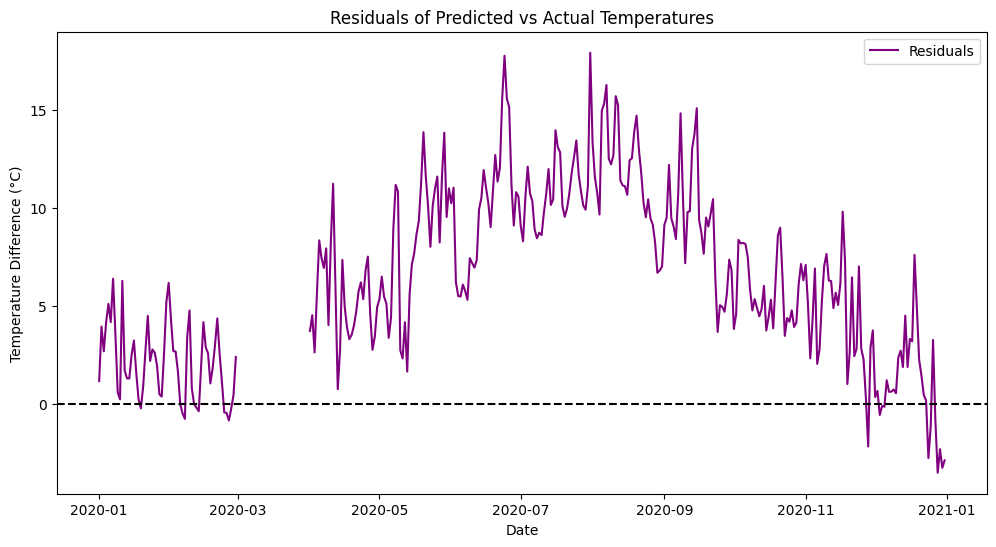

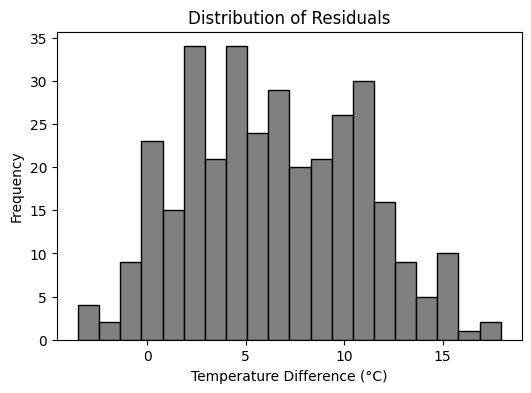

Residuals Descriptive Statistics:
count    335.000000
mean       6.423052
std        4.394764
min       -3.514464
25%        2.823661
50%        6.188036
75%        9.933244
max       17.946605
dtype: float64


In [173]:
# Check for NaN values in the actual and predicted data
if actual_data['Av temp'].isnull().any() or future_predictions.isnull().any():
    print("NaN values found.")

    combined_data = pd.concat([actual_data['Av temp'], future_predictions], axis=1).dropna()
    actual_data_cleaned = combined_data.iloc[:, 0]
    future_predictions_cleaned = combined_data.iloc[:, 1]

# evaluation metrics
mse = mean_squared_error(actual_data_cleaned, future_predictions_cleaned)
mae = mean_absolute_error(actual_data_cleaned, future_predictions_cleaned)
r2 = r2_score(actual_data_cleaned, future_predictions_cleaned)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared ($R^2$): {r2:.2f}')

residuals = actual_data['Av temp'] - future_predictions

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.title('Residuals of Predicted vs Actual Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature Difference (°C)')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.show()

# Histogram
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=20, color='grey', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Temperature Difference (°C)')
plt.ylabel('Frequency')
plt.show()

print("Residuals Descriptive Statistics:")
print(residuals.describe())

**7. Playground** - Prophet Model

00:19:39 - cmdstanpy - INFO - Chain [1] start processing
00:19:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


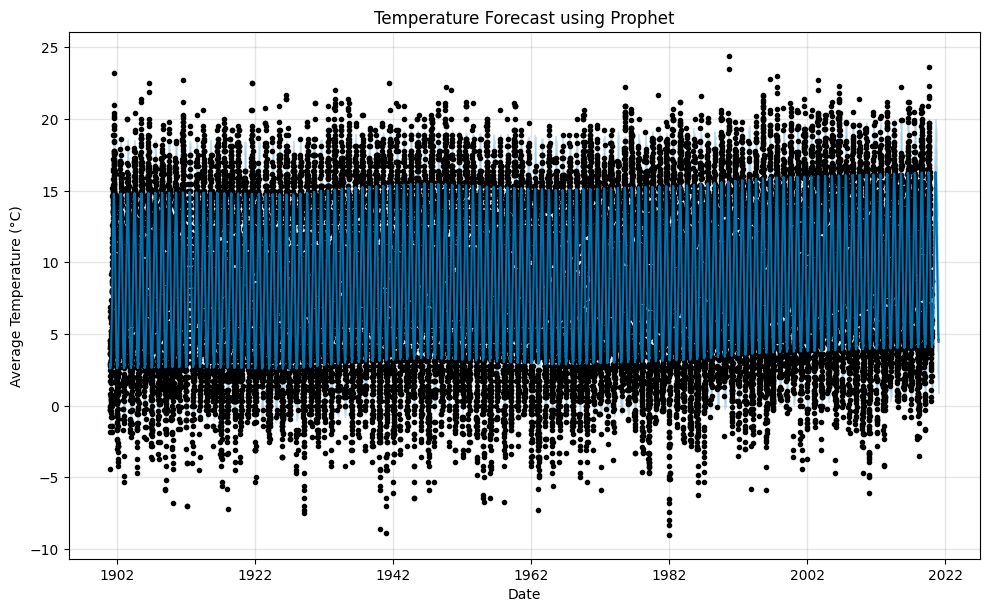

c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\huixi\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

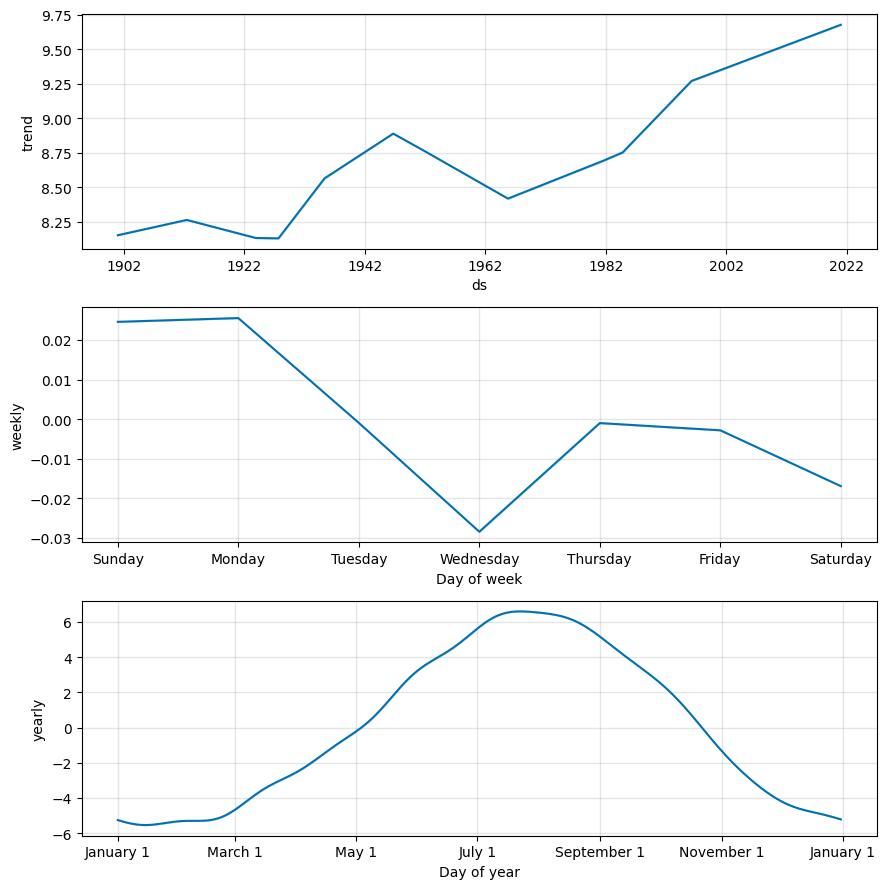

In [174]:
# Prepare the data for Prophet
prophet_data = data.reset_index().rename(columns={'Date': 'ds', 'Av temp': 'y'})

model = Prophet()

# Fit the model with the data
model.fit(prophet_data)

# Create a dataframe for future predictions
future = model.make_future_dataframe(periods=366)

forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('Temperature Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.show()

fig2 = model.plot_components(forecast)

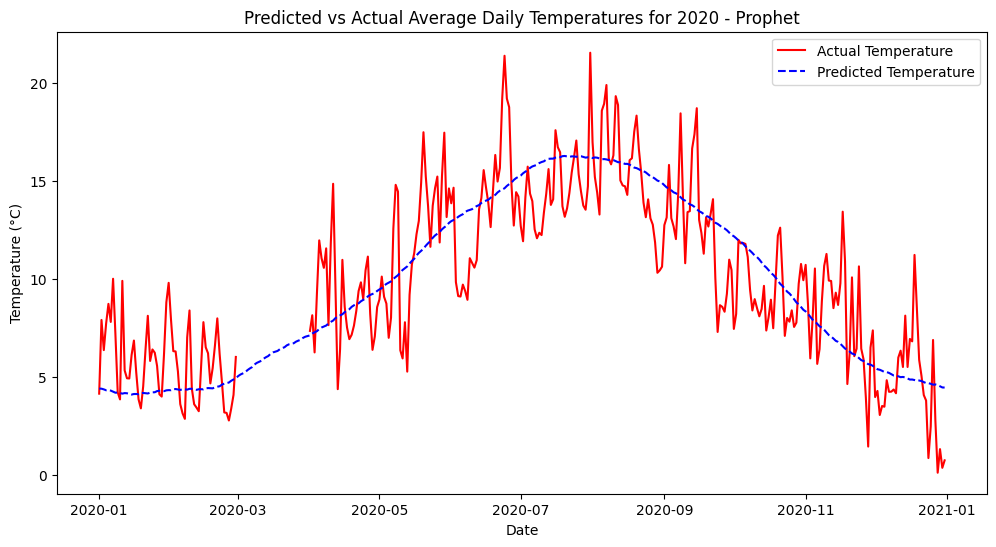

NaN values found.
Mean Squared Error (MSE): 6.37
Mean Absolute Error (MAE): 2.04
R-squared ($R^2$): 0.67


In [175]:
prophet_predictions = forecast.set_index('ds')['yhat'].rename('Predicted Temp')

prophet_predictions = prophet_predictions.reindex(actual_data.index)

plt.figure(figsize=(12, 6))
plt.plot(actual_data['Av temp'], label='Actual Temperature', color='red')
plt.plot(prophet_predictions, label='Predicted Temperature', color='blue', linestyle='--')
plt.title('Predicted vs Actual Average Daily Temperatures for 2020 - Prophet')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

if actual_data['Av temp'].isnull().any() or prophet_predictions.isnull().any():
    print("NaN values found.")
    combined_data = pd.concat([actual_data['Av temp'], prophet_predictions], axis=1).dropna()
    actual_data_cleaned = combined_data.iloc[:, 0]
    prophet_predictions_cleaned = combined_data.iloc[:, 1]
else:
    actual_data_cleaned = actual_data['Av temp']
    prophet_predictions_cleaned = prophet_predictions

mse = mean_squared_error(actual_data_cleaned, prophet_predictions_cleaned)
mae = mean_absolute_error(actual_data_cleaned, prophet_predictions_cleaned)
r2 = r2_score(actual_data_cleaned, prophet_predictions_cleaned)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared ($R^2$): {r2:.2f}')

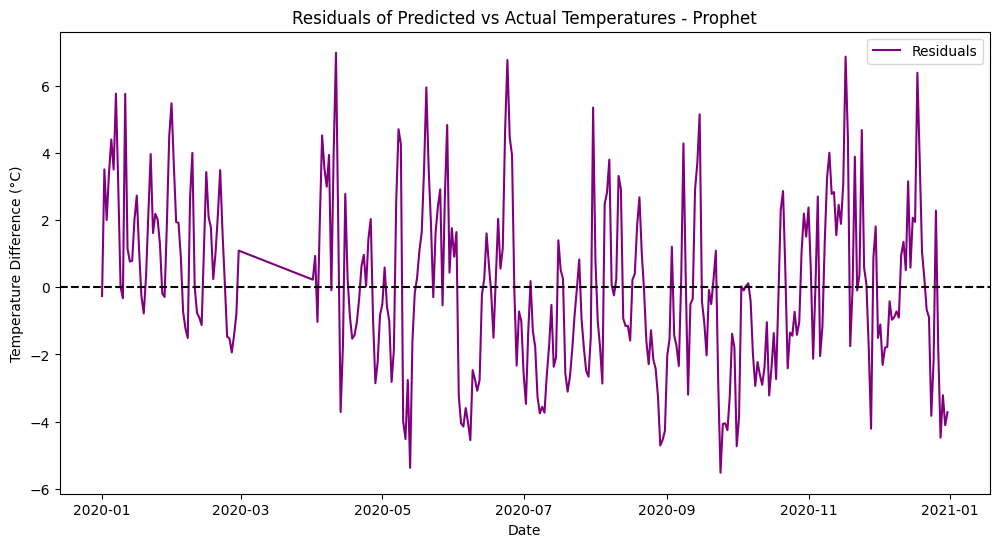

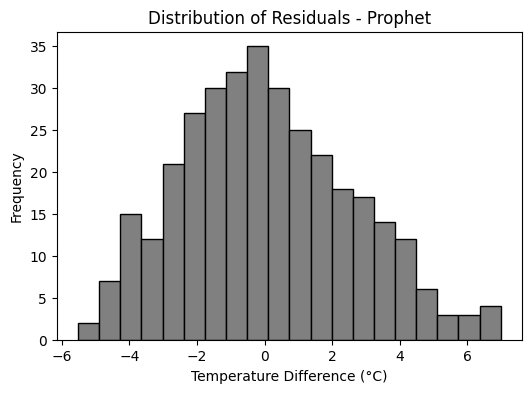

Residuals Descriptive Statistics - Prophet:
count    335.000000
mean       0.059525
std        2.526973
min       -5.522595
25%       -1.762028
50%       -0.091007
75%        1.860900
max        6.989380
dtype: float64


In [176]:
residuals = actual_data_cleaned - prophet_predictions_cleaned

plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.title('Residuals of Predicted vs Actual Temperatures - Prophet')
plt.xlabel('Date')
plt.ylabel('Temperature Difference (°C)')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=20, color='grey', edgecolor='black')
plt.title('Distribution of Residuals - Prophet')
plt.xlabel('Temperature Difference (°C)')
plt.ylabel('Frequency')
plt.show()

print("Residuals Descriptive Statistics - Prophet:")
print(residuals.describe())